# Data Exploration and Baseline
Exploring the data and coming up with baseline classification results.

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
pd.set_option('display.mpl_style', 'default') 

%matplotlib inline

In [41]:
sample = pd.read_csv('Gesture Data/Gesture6_Example1.txt', header=None)

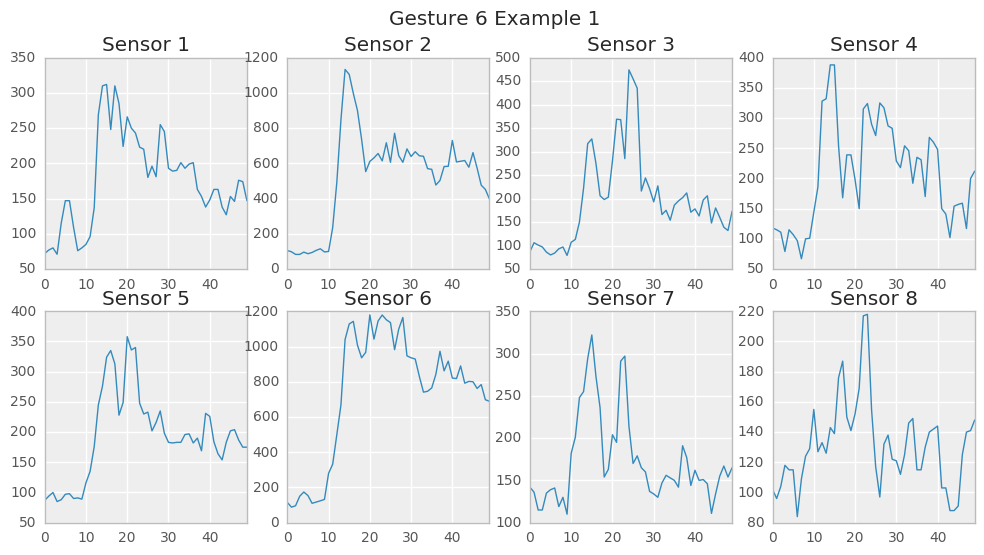

In [42]:
# Visualize the sensor data from each channel
import matplotlib.gridspec as gridspec
fig = plt.figure(figsize=(12, 6), dpi= 80, facecolor='w', edgecolor='k')
ax1 = fig.add_subplot(241)
ax1.set_title('Sensor 1')
ax2 = fig.add_subplot(242)
ax2.set_title('Sensor 2')
ax3 = fig.add_subplot(243)
ax3.set_title('Sensor 3')
ax4 = fig.add_subplot(244)
ax4.set_title('Sensor 4')
ax5 = fig.add_subplot(245)
ax5.set_title('Sensor 5')
ax6 = fig.add_subplot(246)
ax6.set_title('Sensor 6')
ax7 = fig.add_subplot(247)
ax7.set_title('Sensor 7')
ax8 = fig.add_subplot(248)
ax8.set_title('Sensor 8')



sns.tsplot(data=sample[0], ax=ax1)
sns.tsplot(data=sample[1], ax=ax2)
sns.tsplot(data=sample[2], ax=ax3)
sns.tsplot(data=sample[3], ax=ax4)
sns.tsplot(data=sample[4], ax=ax5)
sns.tsplot(data=sample[5], ax=ax6)
sns.tsplot(data=sample[6], ax=ax7)
sns.tsplot(data=sample[7], ax=ax8)

st = fig.suptitle("Gesture 6 Example 1", fontsize="x-large")

plt.subplots_adjust(wspace=0.2, hspace=0.2)

In [5]:
#Create the baseline dataset by flattening the channels into a 1D vector
def create_dataset():
    dataset = np.zeros([12000, 400])
    path = 'Gesture Data/Gesture'
    for i in range(6):
        for j in range(2000):
            sample_path = path + str(i+1) + '_Example' + str(j+1) + '.txt'
            sample = pd.read_csv(sample_path, header=None)
            #print sample.shape
            row = np.concatenate((np.array(sample[0]).T, np.array(sample[1]).T, np.array(sample[2]).T, np.array(sample[3]).T, 
                     np.array(sample[4]).T, np.array(sample[5]).T, np.array(sample[6]).T, np.array(sample[7]).T), 
                     axis=0)
            rowindex = j + 2000*i
            try:
                dataset[rowindex, :] = row
            except:
                pass
    return dataset

In [6]:
dataset = create_dataset()
dataset = pd.DataFrame(dataset)

In [7]:
#Assign Labels to the Dataset
dataset.is_copy=False
dataset['Label'] = 'One'
dataset['Label'][2000:4000] = 'Two'
dataset['Label'][4000:6000] = 'Three'
dataset['Label'][6000:8000] = 'Four'
dataset['Label'][8000:10000] = 'Five'
dataset['Label'][10000:12000] = 'Six'

In [8]:
test = dataset
test = test.loc[test[25] != 0]

In [9]:
test.shape

(11986, 401)

In [10]:
#Split dataset into training/validation set for baseline
from sklearn.model_selection import train_test_split
test = test.sample(frac=1).reset_index(drop=True)
X = test.drop(['Label'], 1)
y = test['Label']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [11]:
from sklearn.linear_model import LogisticRegression
C = [10, 1, .1, .001]

for c in C:
    clf = LogisticRegression(penalty='l1', C=c)
    clf.fit(X_train, y_train)
    print 'C:', c
    print 'Training accuracy:', clf.score(X_train, y_train)
    print 'Test accuracy:', clf.score(X_test, y_test)

C: 10
Training accuracy: 0.826221692491
Test accuracy: 0.753893214683
C: 1
Training accuracy: 0.826221692491
Test accuracy: 0.754449388209
C: 0.1
Training accuracy: 0.8252681764
Test accuracy: 0.756674082314
C: 0.001
Training accuracy: 0.798450536353
Test accuracy: 0.78170189099


In [16]:
test.to_csv('Baseline.csv')

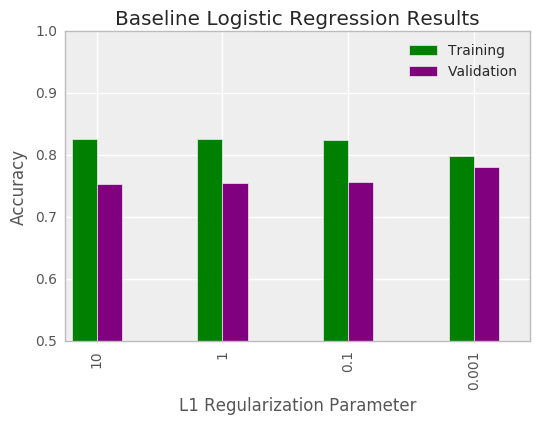

In [29]:
#Visualizing the Results
lr_train = [0.826221692491, 0.826221692491, 0.8252681764, 0.798450536353]
lr_valid = [0.753893214683, 0.754449388209, 0.756674082314, 0.78170189099]
c = [10, 1, 0.1, 0.001]

df = pd.DataFrame()
df['Training'] = lr_train
df['Validation'] = lr_valid
df.index = ['10', '1', '0.1', '0.001']
fig = plt.figure() 

ax = fig.add_subplot(111) 

width = 0.2

df['Training'].plot(kind='bar', color='green', ax=ax, width=width, position=1)
df['Validation'].plot(kind='bar', color='purple', ax=ax, width=width, position=0)
ax.set_ylabel('Accuracy')
ax.set_xlabel('L1 Regularization Parameter')
ax.legend(('Training', 'Validation'))
ax.set_ylim([0.5, 1.0])
plt.title('Baseline Logistic Regression Results')

plt.show()

In [43]:
#Random Forest Baseline
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier



model = RandomForestClassifier(n_jobs=7)
model.fit(X_train, y_train)

print 'Training accuracy:', model.score(np.array(X_train),np.array(y_train))
print 'Test accuracy:', model.score(np.array(X_test), np.array(y_test))

Training accuracy: 0.994040524434
Test accuracy: 0.780867630701


In [44]:
#XGBoost Baseline
import xgboost
model = xgboost.XGBClassifier(learning_rate =0.2,
 n_estimators=3000,
 max_depth=4,
 min_child_weight=1,
 gamma=0.1,
 subsample=0.8,
 colsample_bytree=0.8,
 reg_alpha=0.005,
 objective= 'multi:softmax',
 nthread=8,
 scale_pos_weight=1,
 seed=22)

#xgdmat = xgboost.DMatrix(X_train, y_train)
#xgdmat2 = xgboost.DMatrix(X_test, y_test)
model.fit(np.array(X_train), np.array(y_train))

print 'Training accuracy:', model.score(np.array(X_train),np.array(y_train))
print 'Test accuracy:', model.score(np.array(X_test), np.array(y_test))

/usr/local/lib/python2.7/dist-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


Training accuracy: 1.0
Test accuracy: 0.836763070078
